In [1]:
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *

# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM, IntegralDomain

In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1, U2: pyro.sample("X", dist.Normal(U1, 0.1)), 'X'),
                             Functor(lambda U1: pyro.sample("Y", dist.Normal(U1, 0.1)), 'Y'),
                             Functor(lambda Y, U2: pyro.sample("Z", dist.Normal(Y, 0.1)), 'Z')}, sampler_over)

def sampler_over():
    return dict()

fcm = FunctionalCausalModel({Functor(lambda: pyro.sample("age", dist.Uniform(55, 76)), 'age'),
                            Functor(lambda: pyro.sample("bmi", dist.Normal(27, 0.7)), 'bmi'),
                            Functor(lambda age, bmi:   pyro.sample("aspirin",
                                                        dist.Bernoulli(torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi))), 'aspirin'),
                            Functor(lambda age, bmi:  pyro.sample("statin", dist.Bernoulli(torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi))), 
                                    'statin'),
                            Functor(lambda age, bmi, statin, aspirin: pyro.sample("cancer", 
                                                        dist.Bernoulli(torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin))), 'cancer'),
                            Functor(lambda age, bmi, statin, aspirin, cancer: pyro.sample("y", dist.Normal(6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer, 0.4)), 'y')},
                           sampler_over)
# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')

In [10]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
                      contextual_variables={"age", "bmi"}, target='y')
ccg = MPSDAGController.simplify(ccg)
space = [BoolDomain('aspirin'), BoolDomain('statin'), IntegralDomain('age', 55, 76), IntegralDomain('bmi', 23, 31)]
gpf = GPFunctorFactory(space)

In [11]:
mpses = list(MPSGenerator.mps_for(ccg.interventional_variables, ccg.contextual_variables))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
25
set()
call
set()
call
{'bmi'}
call
{'age'}
call
set()
call
set()
call
{'bmi'}
call
{'age'}
call
set()
call
{'aspirin'} set()
{'aspirin'} {'aspirin'}
set()
call
{'aspirin'} set()
{'aspirin'} {'aspirin'}
{'bmi'}
call
{'aspirin', 'bmi'} {'bmi'}
{'aspirin', 'bmi'} {'aspirin', 'bmi'}
{'age'}
call
{'aspirin', 'age'} {'age'}
{'aspirin', 'age'} {'aspirin', 'age'}
set()
call
{'statin'} set()
{'statin'} {'statin'}
set()
call
set()
call
set()
call
set()
call
set()
call
{'bmi'}
call
{'age'}
call
{'aspirin', 'age'} {'age'}
{'aspirin', 'age'} {'aspirin', 'age'}
set()
call
{'statin'} set()
{'statin'} {'statin'}
set()
call
set()
call
set()
call
set()
call
set()
call
{'bmi'}
call
{'aspirin', 'bmi'} {'bmi'}
{'aspirin', 'bmi'} {'aspirin', 'bmi'}
{'age'}
call
{'bmi'}
call
{'statin', 'bmi'} {'bmi'}
{'statin', 'bmi'} {'statin', 'bmi'}
{'age'}
call
{'statin', 'age'} {'age'}
{'statin', 'age'} {'statin', 'age'}
{'bmi'}
call
{'age'}
call
{'statin', 'age'} {'age'}
{'statin', 'age'} {'statin', 'age'}
set

In [12]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x7fe79270feb0>, ),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fe79270ff40>,
  <aspirin, {'age', 'bmi'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fe7926f9df0>,
  <statin, {'age', 'bmi'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fe792711460>,
  <aspirin, {'age', 'bmi'}>	<statin, {'age', 'bmi'}>)]

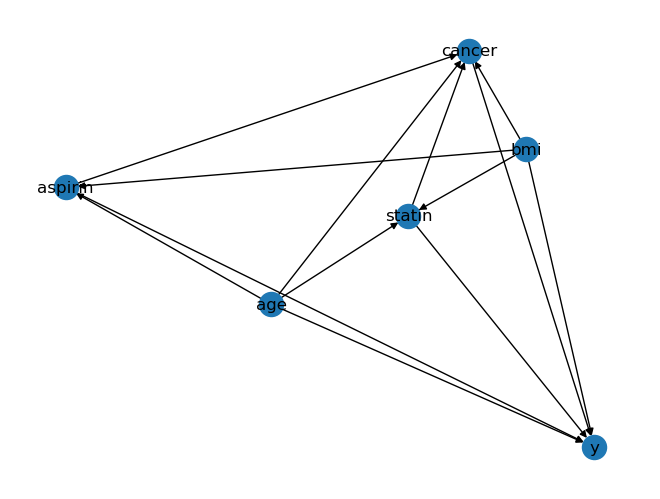

In [13]:
graph, mps = graph_under_mps[-1]
nx.draw(graph, with_labels=True)
policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [14]:
smp

{'age': tensor(75.2626),
 'bmi': tensor(26.6122),
 'aspirin': tensor(True),
 'statin': tensor(True),
 'cancer': tensor(0.),
 'y': tensor(5.9099)}

In [15]:
for i in tqdm(range(80)):
    smp = fcm_m.sample()
    y = smp[graph.target]
    y = torch.tensor([y])
    for p in policy:
        p.functional.observe(-y)
    print(smp)

  0%|          | 0/80 [00:00<?, ?it/s]

{'age': tensor(61.7895), 'bmi': tensor(27.5788), 'aspirin': tensor(False), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.2002)}
{'age': tensor(58.2671), 'bmi': tensor(27.1657), 'aspirin': tensor(False), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.0499)}
{'age': tensor(56.1453), 'bmi': tensor(27.7489), 'aspirin': tensor(True), 'statin': tensor(True), 'cancer': tensor(1.), 'y': tensor(5.6669)}
{'age': tensor(75.3726), 'bmi': tensor(26.6141), 'aspirin': tensor(False), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.5396)}
{'age': tensor(58.7670), 'bmi': tensor(26.0918), 'aspirin': tensor(True), 'statin': tensor(True), 'cancer': tensor(1.), 'y': tensor(6.8597)}
{'age': tensor(57.0771), 'bmi': tensor(26.8663), 'aspirin': tensor(True), 'statin': tensor(True), 'cancer': tensor(0.), 'y': tensor(4.8628)}
{'age': tensor(58.5959), 'bmi': tensor(26.4831), 'aspirin': tensor(True), 'statin': tensor(True), 'cancer': tensor(0.), 'y': tensor(5.3204)}
{'age':

{'age': tensor(67.9308), 'bmi': tensor(27.3889), 'aspirin': tensor(True), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.3894)}
{'age': tensor(58.7606), 'bmi': tensor(27.7426), 'aspirin': tensor(True), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.6652)}
{'age': tensor(59.9916), 'bmi': tensor(28.1138), 'aspirin': tensor(True), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.6466)}
{'age': tensor(69.3028), 'bmi': tensor(28.1748), 'aspirin': tensor(True), 'statin': tensor(False), 'cancer': tensor(1.), 'y': tensor(7.2712)}
{'age': tensor(71.5879), 'bmi': tensor(27.0440), 'aspirin': tensor(False), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.4872)}
{'age': tensor(69.7064), 'bmi': tensor(26.8828), 'aspirin': tensor(True), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.9693)}
{'age': tensor(60.9534), 'bmi': tensor(26.1849), 'aspirin': tensor(True), 'statin': tensor(False), 'cancer': tensor(0.), 'y': tensor(5.7016)}
{'age

In [6]:
import pandas as pd
pd.DataFrame({'a': [1,2,3], 'b': ['a', 'b', 'c']}).to_dict(orient='records')[0]

{'a': 1, 'b': 'a'}

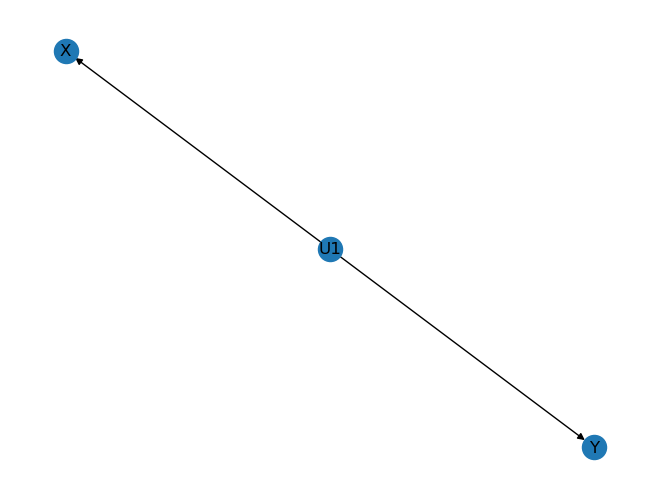

In [12]:
gr = fcm.induced_graph()
gr.contextual_variables = {'Z'}
gr.interventional_variables = {'X'}
sm_gr = MPSDAGController.simplify(gr)
nx.draw(sm_gr, with_labels=True)

In [8]:
sm_gr.contextual_variables, sm_gr.interventional_variables, sm_gr.target, sm_gr.uc_variables

(set(), set(), 'Y', {'U1'})

In [6]:
dr = (nx.DiGraph([('X1', 'X2'), ('C', 'X2'), ('X2', 'Y'), ("U1", "X2"),
                  ("U1", "Y"), ("U2", "X1"), ("U2", "C"), ("C", "Y"), ("U3", "Y")]))
graph = ContextualCausalGraph(edges=dr, uc_variables='auto')
graph.uc_variables

{'U1', 'U2'}

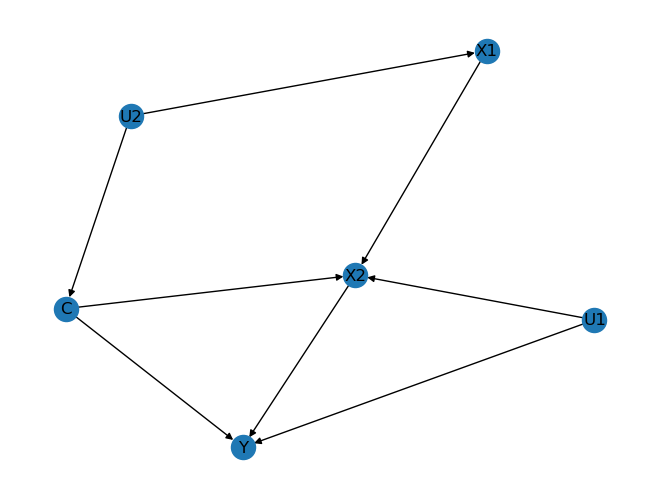

In [9]:
nx.draw(graph, with_labels=True)

In [8]:
mps = MixedPolicyScope([PolicyComponent('X1', {'C'})])
mps_graph, flag = MPSDAGController.graph_under_mps(mps, graph)
assert flag

NetworkXError: The node X1 is not in the digraph.

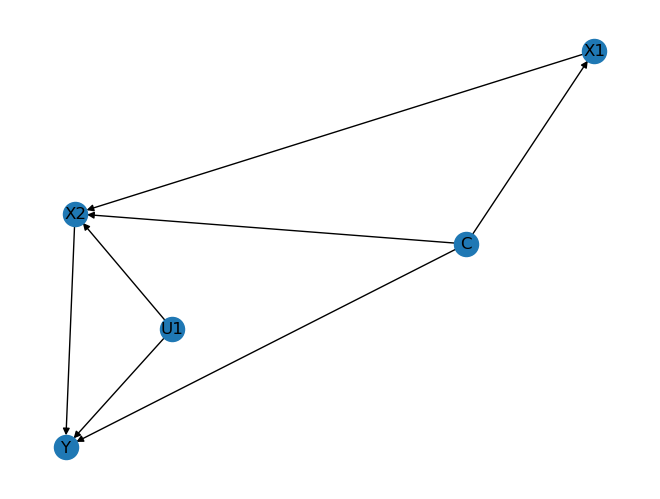

In [5]:
nx.draw(mps_graph, with_labels=True)